/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


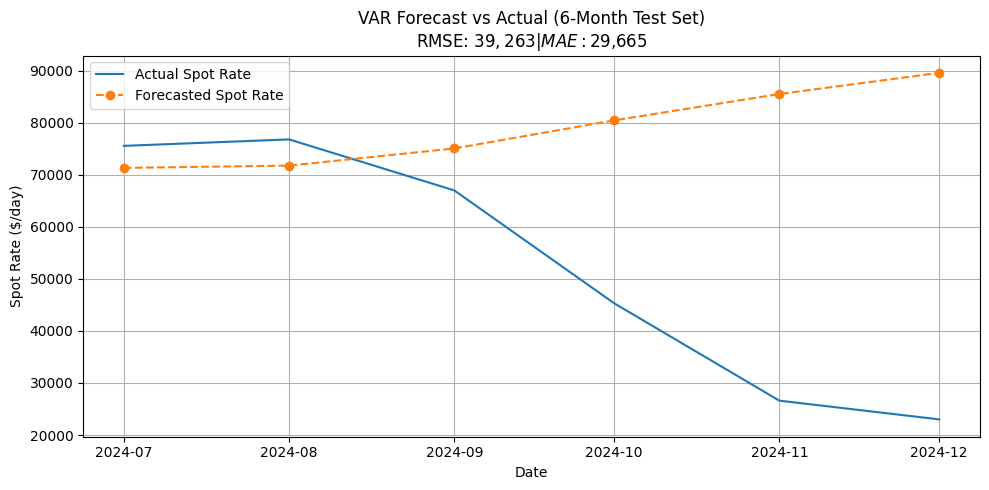

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

# Load and prepare data
df = pd.read_csv("datatest_3.csv")
df.columns = df.columns.str.strip().str.replace('\n', ' ')
df["Date"] = pd.to_datetime(df["Date"], format="%b-%Y", errors='coerce')
df = df.set_index("Date").sort_index()

# Select variables
var_df = df[[
    "LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)",
    "LNG Capacity (CBM)",
    "Spread ASIA-US", "Spread EU-US", "Spread ASIA-EU"
]].dropna()
var_df.columns = ["SpotRate_174k", "LNG_Capacity", "Spread_Asia_US", "Spread_EU_US", "Spread_Asia_EU"]

# Difference non-stationary variables
def adf_test(series): return adfuller(series.dropna(), autolag="AIC")[1]
if adf_test(var_df["LNG_Capacity"]) > 0.05:
    var_df["LNG_Capacity"] = var_df["LNG_Capacity"].diff()
if adf_test(var_df["Spread_Asia_US"]) > 0.05:
    var_df["Spread_Asia_US"] = var_df["Spread_Asia_US"].diff()
if adf_test(var_df["Spread_EU_US"]) > 0.05:
    var_df["Spread_EU_US"] = var_df["Spread_EU_US"].diff()

var_df = var_df.dropna()

# Split into train/test (last 6 months = test)
train = var_df[:-6]
test = var_df[-6:]

# Fit VAR model
model = VAR(train)
results = model.fit(maxlags=2, ic='aic')

# Forecast 6 steps ahead
forecast = results.forecast(train.values[-results.k_ar:], steps=6)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=train.columns)

# Evaluate Spot Rate forecast
y_true = test["SpotRate_174k"]
y_pred = forecast_df["SpotRate_174k"]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="Actual Spot Rate")
plt.plot(y_pred, label="Forecasted Spot Rate", marker='o', linestyle='--')
plt.title(f"VAR Forecast vs Actual (6-Month Test Set)\nRMSE: ${rmse:,.0f} | MAE: ${mae:,.0f}")
plt.xlabel("Date")
plt.ylabel("Spot Rate ($/day)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
